In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms 
from torchvision.models import DenseNet

from tensorboardX import SummaryWriter

import time
import tables
import random
import math

import os,sys
import glob

import PIL 
import cv2
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn import model_selection
import sklearn.feature_extraction.image
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [58]:
# GPU related 

gpuid = 0
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11018MB, multi_processor_count=68)


In [59]:
# sets the number of classes
num_classes = 2

# sets the number of channels
in_channels = 3

# DenseNet parameters 
growth_rate = 32
block_config = (2,2,2,2)
num_init_features = 80
bn_size = 4
drop_rate = 0

# model creation 
model = DenseNet(growth_rate=growth_rate, block_config = block_config,
                 num_init_features = num_init_features,
                 bn_size = bn_size,
                 drop_rate = drop_rate,
                 num_classes = num_classes).to(device)

print(f"total number of parameters: {sum([np.prod(p.size()) for p in model.parameters()])}")

total number of parameters: 429554


In [60]:
class Dataset(object):
    """
    Creation of the Dataset class that will help to load the items for the training and validation phase
    """
    
    def __init__(self, fname, img_transform = None):
        
        self.fname=fname
        self.img_transform=img_transform
        
        with tables.open_file(self.fname, 'r') as db: 
            
            self.ImgIDs = db.root.imgID[:]
            self.classsizes = db.root.classsizes[:]            
            
            self.imgs = db.root.patch[:]
            self.labels = db.root.label[:].astype(np.uint8)
            
        self.nitems = len(self.ImgIDs)
    
    def __getitem__(self, index):
        
        #with tables.open_file(self.fname, 'r') as db: 
            
            #self.imgs = db.root.patch[:]
            #self.labels = db.root.label[:].astype(np.uint8)
            
        img = self.imgs[index,:,:,:]
        label = self.labels[index]
        
        img_new = img
        
        if self.img_transform is not None:
            
            img_new = self.img_transform(img)
            
        return img_new, label, img 
    
    def __len__(self):
        return self.nitems

In [62]:
# training parameters

batch_size = 50
patch_size = 40
num_epochs = 100
phases = ["train","val"]
phase_size = [28000,8000]
validation_phases = ["val"]

In [63]:
# Transforms
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])

dataset = {}
dataLoader = {}

# Load the dataset
for phase, size in zip(phases,phase_size):
    
    dataset[phase] = Dataset(f"dataset/{phase}_{size}_{patch_size}_{num_classes}classes_CD3p_VS_SOX10p_CD68p_triplefiltered.h5", img_transform = img_transform)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size = batch_size, 
                                   shuffle=True, pin_memory=True)
    
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

train dataset size:	28000
val dataset size:	8000


0


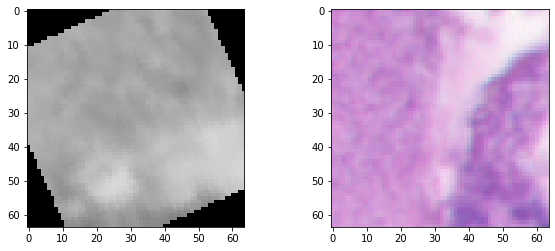

In [23]:
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["val"][5]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

Text(0.5, 1.0, '0')

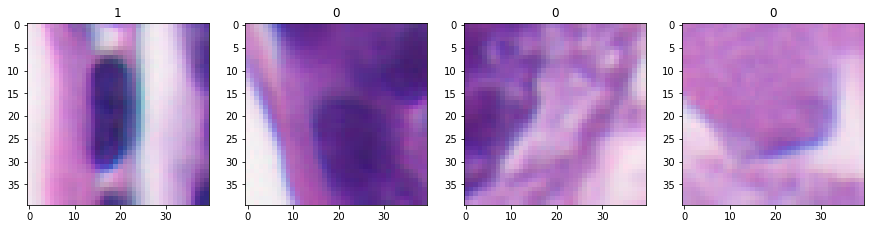

In [9]:
fig, axes = plt.subplots(1,4,figsize = (15,15))

batch = next(iter(dataLoader['train']))

axes[0].imshow(batch[2].numpy()[0,:,:,:])
axes[0].set_title(batch[1].numpy()[0])

axes[1].imshow(batch[2].numpy()[1,:,:,:])
axes[1].set_title(batch[1].numpy()[1])

axes[2].imshow(batch[2].numpy()[2,:,:,:])
axes[2].set_title(batch[1].numpy()[2])

axes[3].imshow(batch[2].numpy()[3,:,:,:])
axes[3].set_title(batch[1].numpy()[3])

In [64]:
# sets the optimizer
optim = torch.optim.Adam(model.parameters())

In [65]:
# Assess class balancing

nclasses = dataset["train"].classsizes.shape[0]
class_weight = dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

criterion = nn.CrossEntropyLoss(weight = class_weight)
print(nclasses)

2


In [66]:
class_weight

tensor([0.5000, 0.5000], device='cuda:0')

## Train

In [67]:
experiment = 0

In [68]:
validation_images = []
pred_labels = []
true_labels = []

training_loss = []
validation_loss = []
validation_acc = []

dataname = 'CD3p_VS_SOX10p_CD68p_triplefilter'
experiment += 1
# Writer for the TensorBoard
writer = SummaryWriter(logdir=f'runs/Experiment_{experiment}_{patch_size}_{nclasses}classes_CD3p_VS_SOX10p_CD68p_triplefilter')
best_loss_on_test = np.Infinity

start_time = time.time()

# Iterate over all epochs
for epoch in range(num_epochs):
    
    all_acc = {key: 0 for key in phases}  # accuracy for all phases: 'train' & 'val'
    all_loss = {key: torch.zeros(0).to(device) for key in phases}  # loss for all phases: 'train' & 'val'
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases} # confusion matrix that is squared for both phases
    
    # For each phase 'train' & 'val'
    for phase in phases: 
        
        if phase == 'train': 
            model.train() # Sets the module in training mode
        else:
            model.eval() # Sets the module in evaluation mode
        
        # For each batch of images and associated labels
        for ii, (X, label, img_orig) in enumerate(dataLoader[phase]):
            
            X = X.to(device) # Convert the image to tensor
            label = label.type('torch.LongTensor').to(device)
            
            
            with torch.set_grad_enabled(phase == 'train'): # enable grad if phase is train
                
                prediction = model(X)
                loss = criterion(prediction,label)
                
                if phase == 'train':
                    
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss
                    
                all_loss[phase] = torch.cat((all_loss[phase], loss.detach().view(1,-1)))
                
                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()
                    
                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))
                    
                    if epoch == 99:
                        
                        validation_images.append(img_orig)
                        pred_labels.append(cpredflat)
                        true_labels.append(yflat)
        
        # For each epoch, save the accuracy of each phase 
        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        # For each epoch, save the loss of each phase 
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        
        # for both phases, save the loss
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            # for validation phase, save the accuracy
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)
                    
    training_loss.append(all_loss['train'])
    validation_loss.append(all_loss['val'])
    validation_acc.append(all_acc['val'])

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f | val acc: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"], all_acc["val"]),end="")    

    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **\n")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'in_channels': in_channels,
         'growth_rate':growth_rate,
         'block_config':block_config,
         'num_init_features':num_init_features,
         'bn_size':bn_size,
         'drop_rate':drop_rate,
         'num_classes':num_classes}


        torch.save(state, f"{dataname}_densenet_best_model.pth")
    else:
        print("\n")
    

0m 23s (- 38m 3s) ([1/100] 1%), train loss: 0.3042 test loss: 0.3043 | val acc: 0.8909  **

0m 46s (- 37m 55s) ([2/100] 2%), train loss: 0.2619 test loss: 0.2463 | val acc: 0.9031  **

1m 9s (- 37m 41s) ([3/100] 3%), train loss: 0.2417 test loss: 0.2235 | val acc: 0.9111  **

1m 33s (- 37m 19s) ([4/100] 4%), train loss: 0.2395 test loss: 0.2330 | val acc: 0.9059

1m 56s (- 36m 59s) ([5/100] 5%), train loss: 0.2325 test loss: 0.2204 | val acc: 0.9127  **

2m 19s (- 36m 29s) ([6/100] 6%), train loss: 0.2321 test loss: 0.2054 | val acc: 0.9149  **

2m 43s (- 36m 6s) ([7/100] 7%), train loss: 0.2228 test loss: 0.3185 | val acc: 0.8911

3m 6s (- 35m 38s) ([8/100] 8%), train loss: 0.2300 test loss: 0.2116 | val acc: 0.9193

3m 29s (- 35m 18s) ([9/100] 9%), train loss: 0.2195 test loss: 0.2387 | val acc: 0.9045

3m 52s (- 34m 56s) ([10/100] 10%), train loss: 0.2176 test loss: 0.2526 | val acc: 0.8920

4m 16s (- 34m 35s) ([11/100] 11%), train loss: 0.2175 test loss: 0.2066 | val acc: 0.9195

4

35m 6s (- 3m 28s) ([91/100] 91%), train loss: 0.1740 test loss: 0.1595 | val acc: 0.9396  **

35m 29s (- 3m 5s) ([92/100] 92%), train loss: 0.1780 test loss: 0.1794 | val acc: 0.9270

35m 53s (- 2m 42s) ([93/100] 93%), train loss: 0.1757 test loss: 0.1726 | val acc: 0.9313

36m 15s (- 2m 18s) ([94/100] 94%), train loss: 0.1806 test loss: 0.1769 | val acc: 0.9261

36m 37s (- 1m 55s) ([95/100] 95%), train loss: 0.1795 test loss: 0.1706 | val acc: 0.9339

37m 0s (- 1m 32s) ([96/100] 96%), train loss: 0.1772 test loss: 0.1738 | val acc: 0.9289

37m 23s (- 1m 9s) ([97/100] 97%), train loss: 0.1739 test loss: 0.1688 | val acc: 0.9310

37m 47s (- 0m 46s) ([98/100] 98%), train loss: 0.1774 test loss: 0.1684 | val acc: 0.9333

38m 10s (- 0m 23s) ([99/100] 99%), train loss: 0.1786 test loss: 0.1723 | val acc: 0.9290

38m 34s (- -1m 59s) ([100/100] 100%), train loss: 0.1765 test loss: 0.1728 | val acc: 0.9325



Text(0, 0.5, 'loss')

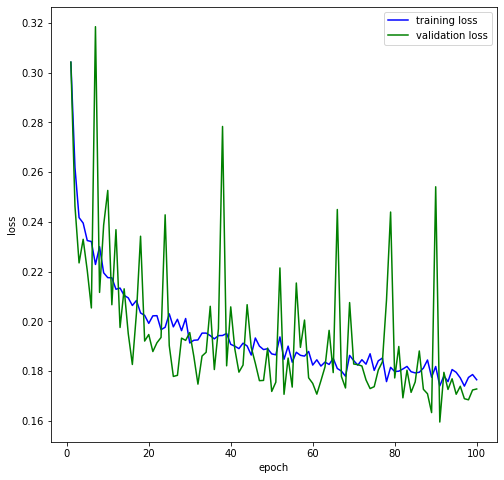

In [69]:
fig, axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(np.arange(1,101,1),training_loss,'b', label = 'training loss')
axes.plot(np.arange(1,101,1),validation_loss, 'g', label = 'validation loss')
axes.legend()
axes.set_xlabel('epoch')
axes.set_ylabel('loss')

#axes.plot(np.arange(1,101,1), validation_acc, 'r', label = 'validation accuracy')
#axes.legend()
#axes.set_xlabel('epoch')
#axes.set_ylabel('accuracy')
#plt.savefig('accuracy.jpeg')

In [29]:
index_=0

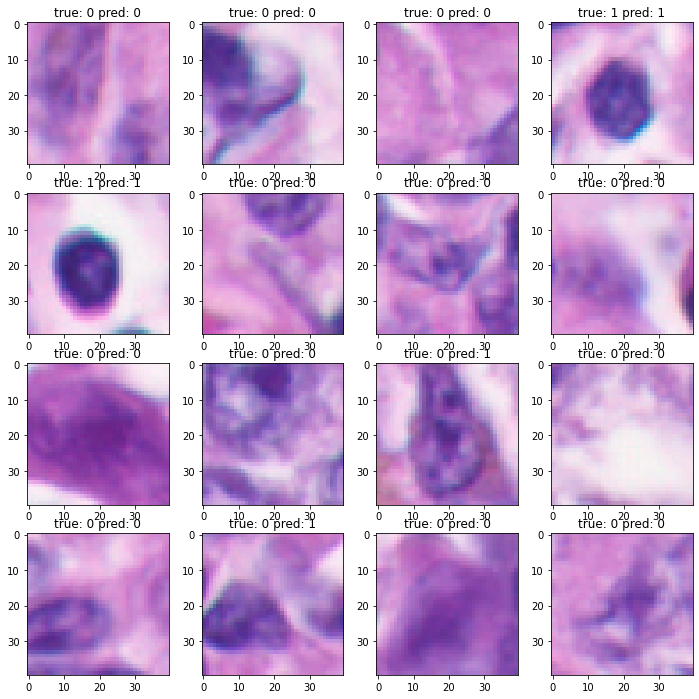

In [30]:
fig,axes = plt.subplots(4,4,figsize=(12,12))

for ax, index in zip(axes.flatten(),range(16)):
    ax.imshow(validation_images[index_][index].numpy())
    ax.set_title("true: {a} pred: {b}".format(a=true_labels[index_][index],b=pred_labels[index_][index]))

index_ += 1 

# Model Test

In [28]:
def predict_image(model, image, img_transform):
    
    image_tensor = img_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    
    input_ = image_tensor.to(device)
    output_ = model(input_)
    
    return output_.data.cpu().numpy().argmax()
    
def accuracy(predictions, true_labels):
    
    counter = 0
    
    for pred, label in zip(predictions, true_labels):
        
        if pred == label:
            
            counter = counter +1
            
    return counter / len(predictions)

def compute_test_accuracy(images, labels, model, img_transform):
    
    pred = []

    for image in images: 
        
        pred.append(predict_image(model=model, image=image, img_transform=img_transform))
    
    return accuracy(pred,labels)

def compute_confusion_matrix(images, model, img_transform, n_classes, true_labels):
    
    confusion_matrix = [[0 for x in range(n_classes)] for y in range(n_classes)]
    
    pred = []
    
    FP_index = []
    FN_index = []
    
    for image in images: 
        
        pred.append(predict_image(model=model, image=image, img_transform=img_transform))
    
    for index, (pred, label) in enumerate(zip(pred, true_labels)):
        
        if (pred == 1) and (label == 1): #True Positive
            
            confusion_matrix[1][1] = confusion_matrix[1][1] + 1
            
        if (pred == 1) and (label == 0): #False Positive
            
            confusion_matrix[0][1] = confusion_matrix[0][1] + 1
            FP_index.append(index)
            
        if (pred == 0) and (label == 0): #True Negative
            
            confusion_matrix[0][0] = confusion_matrix[0][0] + 1
            
        if (pred == 0) and (label == 1): #False Negative
            
            confusion_matrix[1][0] = confusion_matrix[1][0] + 1
            FN_index.append(index)
            
    return confusion_matrix, FP_index, FN_index
    
    

In [29]:
dataname = 'CD3p_VS_SOX10p_CD68p'
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

In [30]:
with tables.open_file('dataset/test_10800_40_2classes_CD3p_VS_SOX10p_CD68p.h5', 'r') as db: 
            
    images = db.root.patch[:]
    labels = db.root.label[:].astype(np.uint8)

In [25]:
set(labels)

{0, 1}

In [27]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [31]:
compute_test_accuracy(images, labels, model, img_transform)

0.7692592592592593

In [32]:
confusion_matrix, FP_index, FN_index = compute_confusion_matrix(images,model,img_transform,2,labels)

In [33]:
confusion_matrix

[[4227, 1173], [1246, 4154]]

In [34]:
TP = confusion_matrix[1][1]
FP = confusion_matrix[0][1]
TN = confusion_matrix[0][0]
FN = confusion_matrix[1][0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
Precision = TP/(TP+FP)
Recall  = TP/(TP+FN)
F1_score = 2*Precision*Recall/(Precision+Recall)

metrics = {'acc' : accuracy, 'precision': Precision, 'recall' : Recall, 'F1-score' : F1_score}

In [35]:
metrics

{'acc': 0.7760185185185186,
 'precision': 0.7798010137037732,
 'recall': 0.7692592592592593,
 'F1-score': 0.7744942668033933}

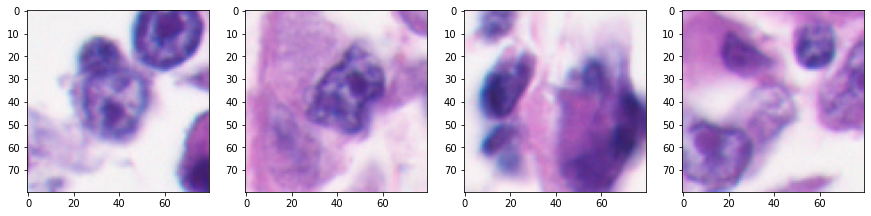

In [58]:
fig, axes = plt.subplots(1,4,figsize=(15,12))

for ax,element in zip(axes.flatten(),FP_index):
    
    ax.imshow(images[element])
    

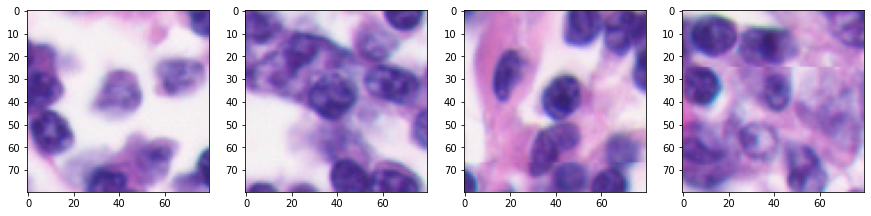

In [59]:
fig, axes = plt.subplots(1,4,figsize=(15,12))

for ax,element in zip(axes.flatten(),FN_index):
    
    ax.imshow(images[element])
    